In [1]:
import sys
sys.path.append("..")

import torch
from torch.utils.data import DataLoader, Subset
import torch.nn.functional as F
from dsvit.model import DSViTDetector
from dsvit.dataset import BrainTumorDataset
from dsvit.utils import (
    plot_confusion_matrix, print_classification_report, plot_roc
)
import numpy as np
import matplotlib.pyplot as plt

In [2]:
classes = {1: 'Meningioma', 2: 'Pituitary', 3: 'Glioma'}
class_names = [classes[i] for i in range(1, 4)]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = DSViTDetector().to(device)
model.load_state_dict(torch.load("/Users/darshdave/Documents/BRAINTUMOR/DSVIT/model-weight/best_dsvit_detector.pth"))
model.eval()

DSViTDetector(
  (pre_encoder): PreEncoder(
    (conv): Sequential(
      (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
  )
  (embedder): MultiScaleEmbedder(
    (proj): Sequential(
      (0): Conv2d(16, 64, kernel_size=(4, 4), stride=(4, 4))
      (1): ReLU()
    )
  )
  (transformer_blocks): ModuleList(
    (0-3): 4 x DenseTransformerBlock(
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
      )
      (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (mlp): Sequential(
        (0): Linear(in_features=64, out_features=128, bias=True)
        (1): GELU(approximate='none')

In [3]:
dataset = BrainTumorDataset("/Users/darshdave/Documents/BRAINTUMOR/DATASET/FILES/")
test_ids = list(range(6))  # use full test split later
test_loader = DataLoader(Subset(dataset, test_ids), batch_size=1)

In [4]:
all_preds, all_labels, all_probs = [], [], []

with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        y_true = y.item()
        bbox_pred, class_logits = model(x)

        probs = F.softmax(class_logits, dim=1).cpu().numpy()
        pred = np.argmax(probs)

        all_preds.append(pred)
        all_labels.append(y_true - 1)
        all_probs.append(probs[0])

all_probs = np.vstack(all_probs)

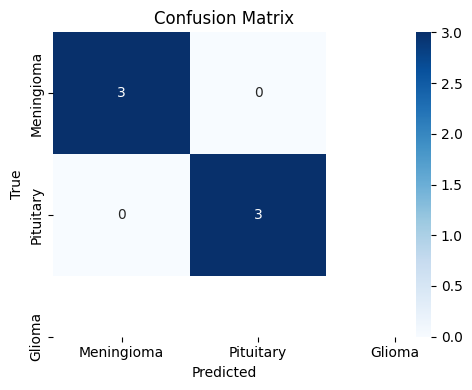

In [5]:
plot_confusion_matrix(all_labels, all_preds, class_names)

In [6]:
print_classification_report(all_labels, all_preds, class_names)

Classification Report:

              precision    recall  f1-score   support

  Meningioma       1.00      1.00      1.00         3
      Glioma       1.00      1.00      1.00         3

    accuracy                           1.00         6
   macro avg       1.00      1.00      1.00         6
weighted avg       1.00      1.00      1.00         6



/Users/darshdave/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


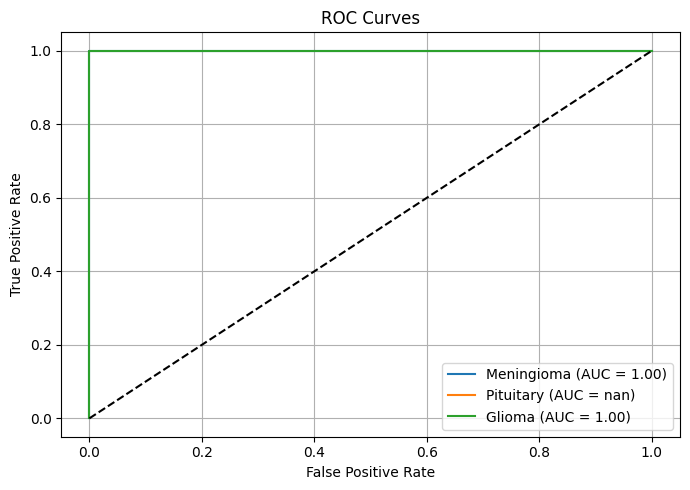

In [7]:
plot_roc(all_labels, all_probs, 3, class_names)

In [8]:
wrong_indices = [i for i in range(len(all_labels)) if all_labels[i] != all_preds[i]]

for idx in wrong_indices[:3]:
    img, _ = dataset[test_ids[idx]]
    plt.imshow(img.squeeze(0).numpy(), cmap='gray')
    plt.title(f"True: {class_names[all_labels[idx]]}, Pred: {class_names[all_preds[idx]]}")
    plt.axis('off')
    plt.show()